### Movies - Images and Text -- Assignment

In this assignment, we will be dealing with a significantly larger and more realistic dataset consisting of both images and text. For this assignment we will use the MMIMDB dataset (http://lisi1.unal.edu.co/mmimdb/), collected by Arévalo, González, Solorio and Montes-y-Gómez from the Universidad Nacional de Colombia, University of Houston, INAOE-México. This dataset contains data corresponding to ~26,000 movies along with their plots (text) and their movie posters (images), and other information such as ratings and genres (categories). These are more movies than you will watch in a lifetime. We will use this dataset for movie genre classification. Each movie can be labeled with 27 categories of movies.

#### 1. Loading and Exploring the Dataset.

First, we download the dataset, then we will create a Dataset class to load both the input movie posters (images), and input movie plots (texts), and the target movie genres (labels). We will also integrate the BertTokenizer from the huggingface transformers library so that the texts are pre-tokenized as they are loaded. The images however will be loaded on the fly as they can not all fit into memory.

In [1]:
!wget -nc http://www.cs.virginia.edu/~vicente/vislang/mmimdb-256.tar.gz
!tar xf mmimdb-256.tar.gz
#!tar xf mmimdb-512.tar.gz # I also keep a copy with images resized at 512 pixels on their largest side.
!pip install livelossplot --quiet
!pip -q install transformers

--2020-10-12 04:09:38--  http://www.cs.virginia.edu/~vicente/vislang/mmimdb-256.tar.gz
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643479473 (614M) [application/x-gzip]
Saving to: ‘mmimdb-256.tar.gz’

mmimdb-256.tar.gz   100%[===================>] 613.67M  37.1MB/s    in 17s     

2020-10-12 04:09:56 (36.1 MB/s) - ‘mmimdb-256.tar.gz’ saved [643479473/643479473]

     |████████████████████████████████| 1.1MB 4.8MB/s 
     |████████████████████████████████| 3.0MB 25.5MB/s 
     |████████████████████████████████| 890kB 38.8MB/s 
     |████████████████████████████████| 1.1MB 40.0MB/s 


In [2]:
import torch, os, json
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from PIL import Image

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, folder = 'dataset-resized-256max', split = 'dev',
                 image_transform = None):
        self.json_dir = os.path.join(folder, split, 'metadata')
        self.image_dir = os.path.join(folder, split, 'images')
        self.image_transform = image_transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Category definitions of movies.
        self.categories = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 
                           'Family', 'Fantasy', 'Film-Noir', 'History', 
                           'Horror', 'Music', 'Musical', 'Mystery', 'News', 
                           'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 
                           'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
        self.categories2ids = {category: id for (id, category) 
                               in enumerate(self.categories)}

        # Load JSON files.
        print('Loading %s ...' % self.json_dir, end = '')
        fdir = os.listdir(self.json_dir)
        self.metadata = [(fname[:-5], json.load(open(os.path.join(self.json_dir, fname)))) 
                     for fname in sorted(fdir) if not fname.startswith('.')]
        print(' finished')

        # Pre-tokenizing all sentences.
        print('Tokenizing...', end = '')
        self.tokenized_plots = list()
        for i in range(0, len(self.metadata)):
            text = self.metadata[i][1]['plot'][0]
            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True, 
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')
            self.tokenized_plots.append(encoded_text)
        print(' finished')
            
    def __getitem__(self, index: int):
        # Load images on the fly.
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        text = self.tokenized_plots[index]['input_ids'][0]
        text_mask = self.tokenized_plots[index]['attention_mask'][0]
        genres = movie_data['genres']

        if self.image_transform: image = self.image_transform(image)

        # Encode labels in a binary vector.
        label_vector = torch.zeros((len(self.categories)))
        label_ids = [self.categories2ids[cat] for cat in genres]
        label_vector[label_ids] = 1

        return image, text, text_mask, label_vector

    def load_image_only(self, index: int):
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        return image

    def get_metadata(self, index: int):
        _, movie_data = self.metadata[index]
        return movie_data

    def __len__(self):
        return len(self.metadata)

val_data = MovieDataset(split = 'dev')
print('Data size: %d samples' % len(val_data))


Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished
Data size: 2608 samples


Print one element from this dataset, both the plot, movie poster, labels, and some of the other metadata. Do not move to the following cells until you understand every line in the code above and below.

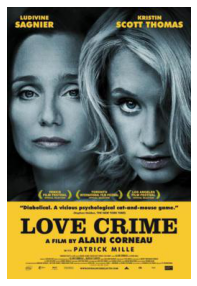

[CLS]
['Crime', 'Mystery', 'Romance', 'Thriller']
Title:  Crime d'amour
Kind:  movie
Year:  2010
Rating:  6.5


In [3]:
import numpy as np

sample_movieID = 2241
img, text, text_mask, labels = val_data[sample_movieID]

# Show input image.
plt.figure(figsize=(4,5));plt.imshow(img); plt.axis(False);plt.show()

# Show input plot (untokenized).
print(val_data.tokenizer.convert_ids_to_tokens(text[0].numpy().tolist()))

# Show target labels (converted back to strings from binary vector).
labels = labels.numpy()
# Is there a better way to do this?
print([val_data.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])

# You can look at other attributes for the movies on this dataset.
movie_metadata = val_data.get_metadata(sample_movieID)
print('Title: ', movie_metadata['smart canonical title'])
print('Kind: ', movie_metadata['kind'])
print('Year: ', movie_metadata['year'])
print('Rating: ', movie_metadata['rating'])

There are 382 movies of type Crime among 2608


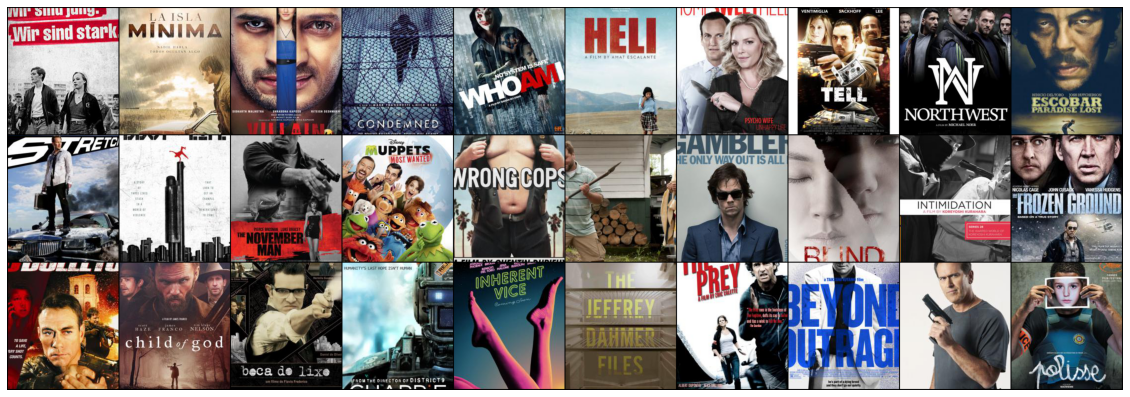

In [4]:
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

# Now let's display a bunch of posters for Crime movies.
movieType = 'Crime'
crime_ids = [id for id in range(0, len(val_data)) \
             if movieType in set(val_data.get_metadata(id)['genres'])]

print('There are %d movies of type %s among %d' % 
      (len(crime_ids), movieType, len(val_data)))

def show_image_group(dataset, image_ids, n_images):
    image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));

# I'm passing the ids in reverse order, because it seems the movies are
# ordered from old to new in the dataset. Try the other way.
show_image_group(val_data, crime_ids[-1:0:-1], 30)

#### 2. Classify the Movies into Genres (based on their Plots) [20pts] 

For this assignment we will not just use BERT encodings but we will use a pretrained BERT model and "fine-tune" its parameters to they adapt to the text in this dataset. This is commonly referred as transfer learning. You can try compare it to a simpler bag-of-words model but this is left as an exercise on your own.

In the code below, we are loading the training, and validation splits and then testing the batch loaders.

In [5]:
# Let's setup the data loaders and preprocessing.
import torchvision.transforms as transforms

# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 10

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = MovieDataset(split = 'train', image_transform = image_transform)
valset = MovieDataset(split = 'dev', image_transform = image_transform)

train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 4)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = batch_size, 
                                         shuffle = False)

Loading dataset-resized-256max/train/metadata ... finished
Tokenizing... finished
Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished


Testing what a sample batch looks like.

In [6]:
_, (imgs, texts, text_masks, labels) = next(enumerate(val_loader))
print(imgs.shape, texts.shape, text_masks.shape, labels.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27])


Here we initialize the pretrained BERT model from the huggingface transformers library. They have several slightly different versions of it that are slightly modified for different tasks so you don't need to manually modify it (e.g. replacing last layer with something else) for your particular task. Do not be surprised if Google Colab keeps crashing. This is a very heavy model so I would recommend only running this cell once. Or if you have to run it twice, you might have to restart the runtime.

In [7]:
from transformers import BertForSequenceClassification, BertConfig

# Loading BERT...
num_categories = len(trainset.categories)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = num_categories,  output_attentions = False, 
    output_hidden_states = False)

# Let's run a quick test on this model on the CPU.
predictions, = model(texts, text_masks)
print(predictions.shape)

# Tell pytorch to run this model on the GPU.
#model.cuda();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

torch.Size([10, 27])


In [ ]:
from transformers import AdamW  # optimizer that comes with this library.
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn

num_epochs = 4

# Following recommendations from the BERT paper and also this
# blog post https://mccormickml.com/2019/07/22/BERT-fine-tuning/
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
# Please see documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

# Are the top five scored labels accurate?
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

# Training Loop. 
best_accuracy = 0
liveloss = PlotLosses(); current_step = 0
for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        texts = texts.cuda()
        text_masks = text_masks.cuda()
        labels = labels.cuda()

        # Compute predictions.
        predicted, = model(texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model.eval()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
        # Move to GPU.
        texts = texts.cuda()
        text_masks = text_masks.cuda()
        labels = labels.cuda()

        # Compute predictions.
        predicted, = model(texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
        num_samples += texts.size(0)

        if (1 + batch_id) % 100 == 0:
            logs['val_loss'] = cumulative_loss / num_samples
            logs['val_accuracy'] = cumulative_accuracy / num_samples    
            liveloss.update(logs, current_step)
            liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth') 

##### 2.1 Show the posters for movies labeld as Comedy with the highest confidence by the BERT model. [20pts]

Use the show_image_group function provided earlier to show the top 30 images scored with the highest scores by the BERT model as Comedy.

In [8]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

model.load_state_dict(torch.load('/content/drive/My Drive/best_model_so_far-vicente (2).pth'))

Mounted at /content/drive


<All keys matched successfully>

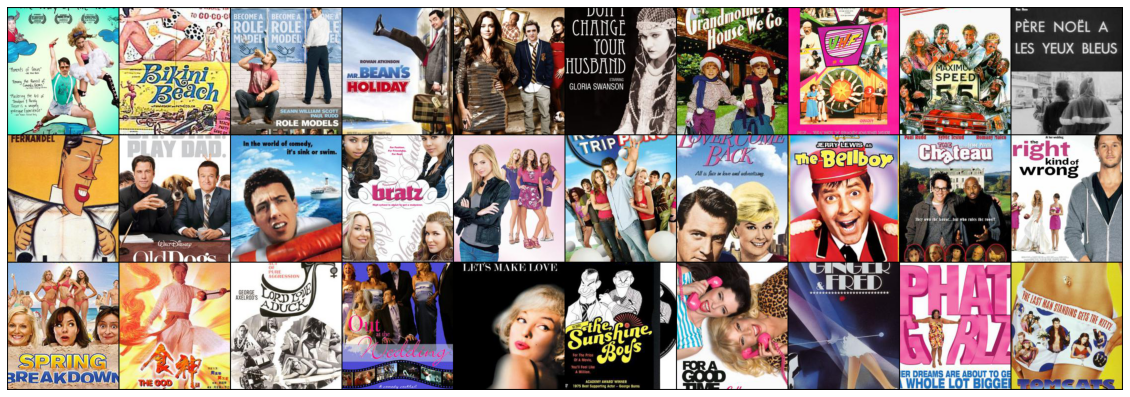

In [9]:
import numpy as np
import heapq

model = model.cuda()
val = []
#texts = texts.cuda()
#text_masks = text_masks.cuda()
#labels = labels.cuda()
for (batch_id, (_, texts, text_masks, labels)) in enumerate(val_loader):
  predicted, = model(texts.cuda(), text_masks.cuda())
  val.append(predicted[:,5].detach().cpu().numpy())

score = np.hstack(np.array(val).ravel())
top30 = heapq.nlargest(30, enumerate(score), key=lambda k: k[1])
sorted_inds = [i[0] for i in top30]

show_image_group(val_data, sorted_inds, 30)

#### 3. Classify the Movies into Genres (based on their Posters) [60pts]




##### 3.1 Training the model [30pts]
For this part feel free to re-use code from the previous sections, the previous assignment, and the previous assignment solutions, as appropriate. You have to at least show your training/validation accuracy and loss plots showing the model is learning and has converged.

In [10]:
# Your code goes here.
import torch
# This solution uses more regularization and more parameters.

class SceneClassifier(torch.nn.Module):
    def __init__(self):
        super(SceneClassifier, self).__init__()
        # Why being conservative? Let's just pick the deepest,
        # biggest model available. This is a small dataset after all,
        # and we have a GPU available thanks to Google Colab. 
        # Wide-Resnet101 has 101 layers deep and double the width of the regular
        # Resnet-101 model.
        # ResNext 101 is also incredibly large and intensive.
        self.pretrained = torchvision.models.resnext101_32x8d(pretrained = True)
        #self.pretrained = torchvision.models.wide_resnet101_2(pretrained = True)
        # I don't want the last layer to do anything.
        self.pretrained.fc = torch.nn.Identity()

        #for param in self.pretrained.parameters():
        #    param.requires_grad = False

        # Create classification layer.
        self.linear = torch.nn.Linear(2048, 27)


    def forward(self, x):
        # I don't want to tune the parameters.
        # I tried tuning but didn't work better so disabling gradients
        # and putting the pretrained network in eval mode.
        #with torch.no_grad():
        #    self.pretrained.eval()
        
        x = self.pretrained(x)
        x = self.linear(x)
        return x


#dummy_batch = torch.zeros(24, 3, 224, 224).cuda()
#my_model = SceneClassifier().cuda()
#y = my_model(dummy_batch)
#print(dummy_batch.shape, y.shape)

model = SceneClassifier()
model = model.cuda()

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [11]:
#!pip install livelossplot --quiet
from livelossplot import PlotLosses
# Are the top five scored labels accurate?
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader):

    # GPU.
    model = model.cuda()
    cost_function = cost_function.cuda()

    best_accuracy = 0 
    liveloss = PlotLosses(); current_step = 0
    for epoch in range(0, n_epochs):
        correct = 0
        cumulative_accuracy = 0
        cumulative_loss = 0
        num_samples = 0
        logs = {}
        model.train()
        for (batch_id, (xb, texts, text_masks, yb)) in enumerate(train_loader):
            model.zero_grad()

            # Move data to GPU.
            xb = xb.cuda()
            yb = yb.cuda()

            # Compute predictions.
            predicted = model(xb)
            # print(xb.shape, yb.shape, predicted.shape)

            # Compute loss.
            loss = cost_function(predicted, yb)
#            cumulative_loss += loss.data
#            predicted_ = predicted.detach().softmax(dim = 1)
#            predicted_ = predicted.detach()
#            max_vals, max_ids = predicted_.max(dim = 1)
#            correct += (max_ids == yb).sum().cpu().item()
            
            # Compute cumulative loss and top-5 accuracy.
            cumulative_loss += loss.data.sum().item()
            cumulative_accuracy += top5_accuracy(predicted, yb).sum().item()
            num_samples += xb.size(0)

            # Backpropagation and SGD update step.
            model.zero_grad()
            loss.mean().backward()
            optimizer.step()
            
            if batch_id % 100 == 0:
                print(epoch, batch_id, cumulative_accuracy / num_samples)
                logs['loss'] = cumulative_loss / num_samples
                logs['accuracy'] = cumulative_accuracy / num_samples
                liveloss.update(logs)
                liveloss.send()
                current_step += 1
        
        cumulative_accuracy = 0
        cumulative_loss = 0
        num_samples = 0
        #     # Compute gradients (autograd).
        #     loss.backward()

        #     # Run one basic training step of SGD.
        #     optimizer.step()

        #     logs['loss'] = cumulative_loss / (1 + batch_id)
        #     logs['accuracy'] = correct / ((batch_id * batch_size) + xb.size(0))
        
        # correct = 0
        # cumulative_loss = 0
        model.eval()
        with torch.no_grad():
            for (batch_id, (xb,texts, text_masks, yb)) in enumerate(val_loader):
                # Move data to GPU.
                xb = xb.cuda()
                yb = yb.cuda()
            
                # Compute predictions.
                predicted = model(xb)

                # Compute loss.
                loss = cost_function(predicted, yb)
#                cumulative_loss += loss.data
                #predicted_ = predicted.detach().softmax(dim = 1)
#                predicted_ = predicted.detach()
#                max_vals, max_ids = predicted_.max(dim = 1)
#                correct += (max_ids == yb).sum().cpu().item()

#                logs['val_loss'] = cumulative_loss / (1 + batch_id)
#                logs['val_accuracy'] = correct / ((1 + batch_id) * batch_size)


                # Compute cumulative loss and top-5 accuracy.
                cumulative_loss += loss.data.sum().item()
                cumulative_accuracy += top5_accuracy(predicted, yb).sum().item()
                num_samples += xb.size(0)

                if (1 + batch_id) % 100 == 0:
                  logs['val_loss'] = cumulative_loss / num_samples
                  logs['val_accuracy'] = cumulative_accuracy / num_samples    
                  liveloss.update(logs, current_step)
                  liveloss.send()


        if scheduler != -1:
            scheduler.step()

        # Save the parameters for the best accuracy on the validation set so far.
        if logs['val_accuracy'] > best_accuracy:
            best_accuracy = logs['val_accuracy']
            torch.save(model.state_dict(), 'best_model_so_far.pth')

        # liveloss.update(logs)
        # liveloss.send()



    # # Load the model parameters for the one that achieved the best val accuracy.
    # model.load_state_dict(torch.load('best_model_so_far.pth'))  

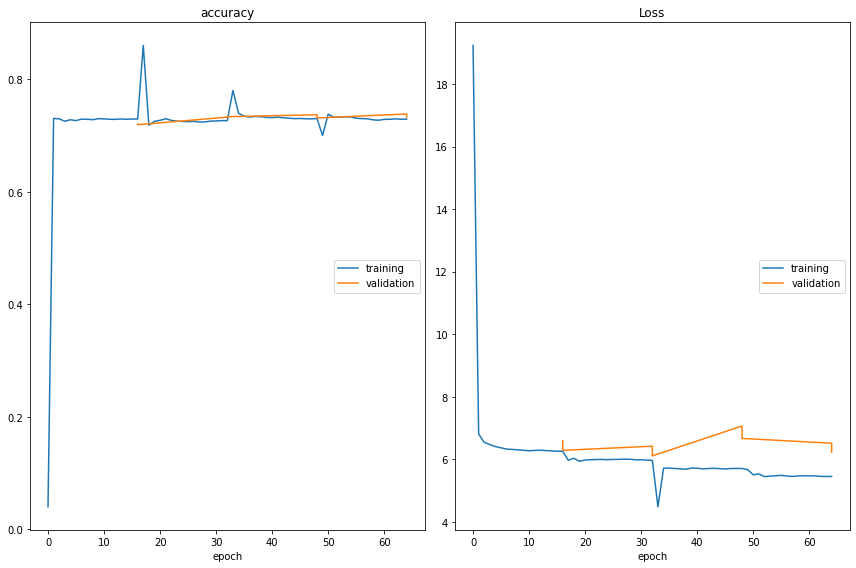

accuracy
	training         	 (min:    0.040, max:    0.860, cur:    0.729)
	validation       	 (min:    0.719, max:    0.738, cur:    0.732)
Loss
	training         	 (min:    4.481, max:   19.235, cur:    5.449)
	validation       	 (min:    6.108, max:    7.062, cur:    6.227)


In [12]:
from transformers import AdamW  # optimizer that comes with this library.
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn

batch_size = 24
n_epochs = 4
learningRate = 1e-3

# I like to use nn.BCEWithLogitsLoss
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

# Same optimizer as before. 
optimizer = torch.optim.Adam([{'params': model.pretrained.parameters(), 'lr': 1e-4},
                              {'params': model.linear.parameters()}], 
                              lr = learningRate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

# # Data setup.
# train_transform = torchvision.transforms.Compose([
#         torchvision.transforms.Resize((256, 256)),
#         torchvision.transforms.RandomCrop((224, 224)),
#         torchvision.transforms.RandomHorizontalFlip(),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                          std=[0.229, 0.224, 0.225]),
#         torchvision.transforms.RandomErasing()])
# test_transform = torchvision.transforms.Compose([
#         torchvision.transforms.Resize((256, 256)),
#         torchvision.transforms.CenterCrop((224, 224)),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                          std=[0.229, 0.224, 0.225])])
# trainset = SUN20(split = 'train', transform = train_transform)
# valset = SUN20(split = 'validation', transform = test_transform)

# train_loader = torch.utils.data.DataLoader(trainset, 
#                                            batch_size = batch_size, 
#                                            shuffle = True, 
#                                            pin_memory = True,
#                                            num_workers = 4)
# val_loader = torch.utils.data.DataLoader(valset, 
#                                          batch_size = batch_size, 
#                                          shuffle = False)

train_model(batch_size, n_epochs, learningRate, 
            model, cost_function, optimizer, scheduler, 
            train_loader, val_loader)

**Required answer:** Is this model better than the text classifier in terms of top-5 accuracy as computed earlier? Which one is better?

In terms of top-5 accuracy, the text classifier model (with 0.748 of accuracy) is better than the image classifier

##### 3.2 Analysis [10pts] 
Show the images classified as "Comedy" with the highest confidence using the above image classifier (show their posters).

In [15]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

model.load_state_dict(torch.load('/content/drive/My Drive/best_model_so_far.pth'))

Mounted at /content/drive


<All keys matched successfully>

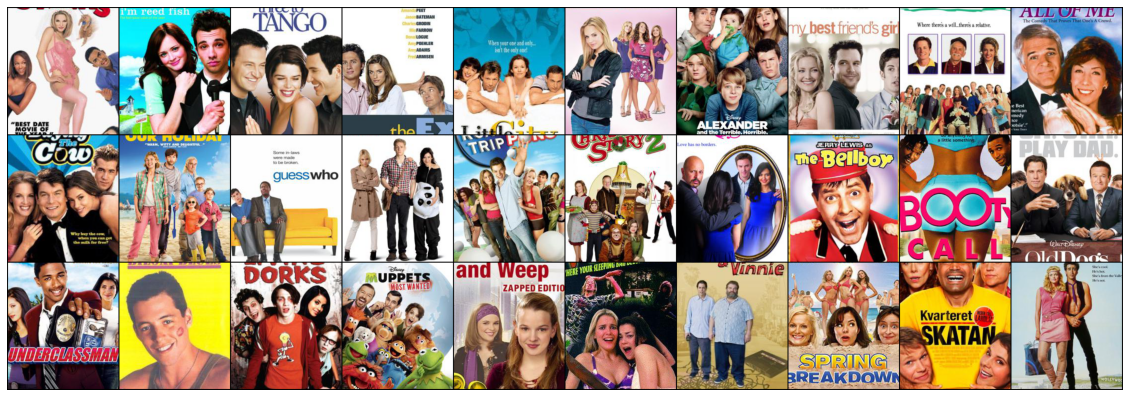

In [19]:
# Your code goes here
val = []
#model = model.cuda()
#texts = texts.cuda()
#text_masks = text_masks.cuda()
#labels = labels.cuda()
for (batch_id, (imgs, _, _, labels)) in enumerate(val_loader):
  predicted = model(imgs.cuda())
  val.append(predicted[:,5].detach().cpu().numpy())

score_img = np.hstack(np.array(val).ravel())
top30_img = heapq.nlargest(30, enumerate(score_img), key=lambda k: k[1])
sorted_inds_img = [i[0] for i in top30_img]

show_image_group(val_data, sorted_inds_img, 30)

##### 3.3 Further Analysis [20pts]
 Is there an overlap in the top 100 images rated as Comedy by the text classifiers and the image classifier? How big is this overlap?

In [22]:
# Compute the overlap here.
top100_img = heapq.nlargest(100, enumerate(score_img), key=lambda k: k[1])
sorted_inds_img_2 = [i[0] for i in top100_img]
top100 = heapq.nlargest(100, enumerate(score), key=lambda k: k[1])
sorted_inds_2 = [i[0] for i in top100]
a = set(sorted_inds_2)
b = set(sorted_inds_img_2)
c = a.intersection(b)
print(len(c))

24


24 images out of 100 images is the overlap of the two models

#### 4. Multimodal Classifier [20pts]

Define below a model that can use as input both the text and image to produce classification scores. **Note:** You don't need to train this model -- only provide the definition and show that it works. That means, test that you can input img, text, text_mask, and get a set of predictions for the labels.

In [24]:
# Your code goes here
class my_model(torch.nn.Module):
    def __init__(self):
        super(my_model, self). __init__()
        # Why being conservative? Let's just pick the deepest,
        # biggest model available. This is a small dataset after all,
        # and we have a GPU available thanks to Google Colab. 
        # Wide-Resnet101 has 101 layers deep and double the width of the regular
        # Resnet-101 model.
        # ResNext 101 is also incredibly large and intensive.
        self.pretrained = torchvision.models.resnext101_32x8d(pretrained = True)
        #self.pretrained = torchvision.models.wide_resnet101_2(pretrained = True)
        # I don't want the last layer to do anything.
        self.pretrained.fc = torch.nn.Identity()

        #for param in self.pretrained.parameters():
        #    param.requires_grad = False

        # Create classification layer.
        self.linear = torch.nn.Linear(2048, 400)

        #For bert
        self.fcb = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
    num_labels = 400,  output_attentions = False, 
    output_hidden_states = False)
        

        self.fcl = torch.nn.Linear(800, 27)
        self.relu = torch.nn.functional.relu


    def forward(self, x, y, z):
        # I don't want to tune the parameters.
        # I tried tuning but didn't work better so disabling gradients
        # and putting the pretrained network in eval mode.
        #with torch.no_grad():
        #    self.pretrained.eval()
        x = self.pretrained(x)
        x = self.pretrained.fc(x)
        x = self.relu(self.linear(x))
        y = self.relu(self.fcb(y, z)[0])
        r = torch.cat([x,y], 1)
        r = self.fcl(r)

        return r

img, text, text_mask, labels = valset[13]
model = my_model()
predictions = model(img.unsqueeze(0), text.unsqueeze(0), text_mask.unsqueeze(0))
print(img.shape, text.shape, text_mask.shape, labels.shape, predictions.shape)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

torch.Size([3, 224, 224]) torch.Size([256]) torch.Size([256]) torch.Size([27]) torch.Size([1, 27])
